# Universidade Federal de Minas Gerais
## Teoria da Decisão - ELE088 
Daniela Amaral Sampaio - 2017074351

Matheus Brito Faria - 2017074386

Victor Emannuel - 2017074394

Importando as bibliotecas que serão utilizadas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import copy

Fazendo a importação do drive com as tabelas para o trabalho

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Obtendo os dados do arquivo i5x25.xlsx disponível para o trabalho computacional

In [ ]:
path = r'/content/drive/MyDrive/UFMG/9º SEMESTRE/TEORIA DA DECISAO/' \
        'Trabalho-Computacional/i5x25.xlsx'
data = pd.read_excel(path, header=1)
time_job_machine = data[[1, 2, 3, 4, 5]][:25].to_numpy()
cost_late_job = data.iloc[:25, -1].to_numpy()
due_date = data.iloc[-1, 1]

Para montar a estrutura de vizinhança, foi utilizada a estrutura abaixo em que a ordem das tarefas a serem executadas em cada maquina é representado pelo index da tarefa corespondente. 

Portanto, a maquina 0 começa com a tarefa 1 depois a 6 e no fim a 23, nesse exemplo.

```
schedule = [
            [ 1,  6, 14,  7, 23], # machine 0
            [24, 21,  0,  3,  9], # machine 1
            [19, 20, 18,  5, 11], # machine 2
            [ 2, 22, 15, 17, 10], # machine 3
            [13, 16,  8, 12,  4]  # machine 4
]
```


A classe *JobShopScheduler* contém as funções que calculam todos os valores das variáveis, entre eles: calcular o tempo de término da tarefa, calcular o makespan, o objetivo, entre outras.

In [ ]:
class JobShopScheduler:
    def __init__(self, 
                 objective_name=None,
                 schedule=None,
                 time_job_machine=time_job_machine, 
                 cost_late_job=cost_late_job, 
                 due_date=due_date):
        self.time_job_machine = time_job_machine
        self.cost_late_job = cost_late_job
        self.due_date = due_date
        self.number_of_machines = time_job_machine.shape[1]
        self.number_of_jobs = time_job_machine.shape[0]
        self.objective_name = objective_name
        self.schedule = schedule if schedule else self.initiate_schedule() 
        self.calculate_time_to_finish()

    def initiate_schedule(self):
        jobs = np.array(range(self.number_of_jobs))
        np.random.shuffle(jobs)
        return np.array_split(jobs, self.number_of_machines)
        
    def calculate_time_to_finish(self):
        time_to_finish = np.zeros(self.number_of_jobs)
        for machine, machine_schedule in enumerate(self.schedule):
            late_time = 0
            for job in machine_schedule:
                time_to_finish[job] = self.time_job_machine[job, machine] + late_time
                late_time = time_to_finish[job]
        self.time_to_finish = time_to_finish 

    def calculate_lateness(self):
        return np.maximum(self.time_to_finish-self.due_date, 
                          np.zeros(self.number_of_jobs))

    def calculate_lateness_cost(self):
        return np.sum(self.calculate_lateness()*self.cost_late_job)

    def calculate_makespan(self):
        return np.max(self.time_to_finish)

    def calculate_objective(self):
        if self.objective_name == 'makespan':
            return self.calculate_makespan()
        elif self.objective_name == 'lateness_cost':
            return self.calculate_lateness_cost()
        elif self.objective_name == 'both': 
            return 100*self.calculate_makespan()+self.calculate_lateness_cost()
        else:
            raise

    def get_schedule(self):
        return self.schedule

    def get_objective_name(self):
        return self.objective_name


# scheduler = JobShopScheduler()
# print(scheduler.calculate_lateness())
# print(scheduler.calculate_lateness_cost())
# print(scheduler.calculate_makespan())

A classe *Shaker* contém diversas funções que executam tipos diferentes de estruturas de vizinhança que podem ser empregadas, como: *shift, switch, task move*, entre outras. 

In [ ]:
class Shaker:
    def __init__(self):
        self.schedule_matrix = list
        self.number_of_jobs_in_machine = int

    def set_schedule(self, schedule):
        self.schedule_matrix = copy(schedule.get_schedule())
        self.number_of_machines = len(self.schedule_matrix)
        self.objective_name = copy(schedule.get_objective_name())

    def shift(self):
        machine_index = self.get_random(self.number_of_machines)
        number_of_jobs_in_machine = len(self.schedule_matrix[machine_index])
        job_index, position_index = self.get_random(
            number_of_jobs_in_machine, 2)
        hold_job = self.schedule_matrix[machine_index][job_index]
        self.schedule_matrix[machine_index] = np.delete(
            self.schedule_matrix[machine_index], job_index)
        self.schedule_matrix[machine_index] = np.insert(
            self.schedule_matrix[machine_index], position_index, hold_job)
        return self.schedule_matrix

    def switch(self):
        machine_index = self.get_random(self.number_of_machines)
        number_of_jobs_in_machine = len(self.schedule_matrix[machine_index])
        job_index, another_job_index = self.get_random(
            number_of_jobs_in_machine, 2)
        self.schedule_matrix[machine_index][[job_index, another_job_index]] = \
        self.schedule_matrix[machine_index][[another_job_index, job_index]]
        return self.schedule_matrix

    def task_move(self):
        machine_index_source, machine_index_destination = self.get_random(
            self.number_of_machines, 2)
        job_index_source = self.get_random(
            len(self.schedule_matrix[machine_index_source]))
        hold_value = self.schedule_matrix[machine_index_source][job_index_source]
        self.schedule_matrix[machine_index_source] = np.delete(
            self.schedule_matrix[machine_index_source], 
            job_index_source)
        job_index_destination = self.get_random(
            len(self.schedule_matrix[machine_index_destination]))
        self.schedule_matrix[machine_index_destination] = np.insert(
            self.schedule_matrix[machine_index_destination], 
            job_index_destination, 
            hold_value)
        return self.schedule_matrix

    def swap(self):
        machine_index_1, machine_index_2 = self.get_random(
            self.number_of_machines, 2)
        job_index_source_1 = self.get_random(
            len(self.schedule_matrix[machine_index_1]))
        hold_value_1 = self.schedule_matrix[machine_index_1][job_index_source_1]
        self.schedule_matrix[machine_index_1] = np.delete(
            self.schedule_matrix[machine_index_1], 
            job_index_source_1)
        job_index_destination_2 = self.get_random(
            len(self.schedule_matrix[machine_index_2]))
        self.schedule_matrix[machine_index_2] = np.insert(
            self.schedule_matrix[machine_index_2], 
            job_index_destination_2, 
            hold_value_1)
        job_index_source_2 = self.get_random(
            len(self.schedule_matrix[machine_index_2]))
        hold_value_2 = self.schedule_matrix[machine_index_2][job_index_source_2]
        self.schedule_matrix[machine_index_2] = np.delete(
            self.schedule_matrix[machine_index_2], 
            job_index_source_2)
        job_index_destination_1 = self.get_random(
            len(self.schedule_matrix[machine_index_1]))
        self.schedule_matrix[machine_index_1] = np.insert(
            self.schedule_matrix[machine_index_1], 
            job_index_destination_1, 
            hold_value_2)
        return self.schedule_matrix

    def shake(self, schedule, level_change):
        self.set_schedule(schedule)
        if level_change == 1:
            return JobShopScheduler(self.objective_name, self.shift())
        elif level_change == 2:
            self.shift()
            return JobShopScheduler(self.objective_name, self.shift())
        elif level_change == 3:
            return JobShopScheduler(self.objective_name, self.switch())
        elif level_change == 4:
            self.switch()
            return JobShopScheduler(self.objective_name, self.switch())
        elif level_change == 5:
            return JobShopScheduler(self.objective_name, self.task_move())
        elif level_change == 6:
            self.task_move()
            return JobShopScheduler(self.objective_name, self.task_move())
        elif level_change == 7:
            return JobShopScheduler(self.objective_name, self.swap())
        else:
            self.swap()
            return JobShopScheduler(self.objective_name, self.swap())


    @staticmethod
    def get_random(low, size=None):
        if size == 1 or not size:
            return np.random.randint(low)
        else:
            return np.random.choice(range(low), size, replace=False)

# shaker = Shaker()
# print(scheduler.get_schedule())
# new = shaker.shake(scheduler, 4)
# print(new.get_schedule())

Se a nova vizinhança tiver um valor da função objetiva menor que a anterior, retorna-se 1 e se inicia uma nova *schedule*. Caso contrário, passa para o próximo nível para analisar mais vizinhanças.

In [ ]:
def neighborhood_change(schedule, new_schedule, level_change):
    if schedule.calculate_objective() <= new_schedule.calculate_objective():
        return level_change+1, schedule 
    else:
        return 1, new_schedule

Nessa função *run_vns*, executa-se a metaheurística RVNS, que é uma variação do VNS. A cada iteração do VNS, parte-se da solução corrente para obter uma solução vizinha aleatória dentro de uma vizinhança k ∈ K. O adicional dessa metaheurística é que esta solução vizinha é então submetida a uma busca local. 

Se a solução gerada for melhor do que a solução corrente, a busca continua a partir dela, retornando-se à primeira estrutura de vizinhança. Caso contrário, continua-se a busca a partir da próxima estrutura de vizinhança k + 1 ∈ K. 



In [ ]:
def run_vns(objective_name, max_iteration=5000):
    iteration = 0
    list_lateness_cost = list()
    list_makespan = list()

    schedule = JobShopScheduler(objective_name)
    shaker = Shaker()

    list_lateness_cost.append(schedule.calculate_lateness_cost())
    list_makespan.append(schedule.calculate_makespan())

    while iteration < max_iteration:
        level_change = 1
        while level_change <= 8:
            new_schedule = shaker.shake(schedule, level_change)
            level_change, schedule = neighborhood_change(schedule, 
                                                         new_schedule, 
                                                         level_change)
        list_lateness_cost.append(schedule.calculate_lateness_cost())
        list_makespan.append(schedule.calculate_makespan())
        # print(f"Iteration {iteration}: objective {schedule.calculate_objective()}")
        iteration += 1

    return schedule, list_lateness_cost, list_makespan

# schedule, list_lateness_cost, list_makespan = run_vns()

O método estocástico RVNS apresentado é executado 5 vezes e abaixo são apresentados os seus resultados

## f1(x): Minimizando makespan

In [ ]:
best_schedule = list()
runs_lateness_cost = list()
runs_makespan = list()

for run in range(5):
    schedule, list_lateness_cost, list_makespan = run_vns('makespan')
    best_schedule.append(schedule.get_schedule())
    runs_makespan.append(np.array(list_makespan))
    runs_lateness_cost.append(np.array(list_lateness_cost))

In [ ]:
best_makespan = [run[-1] for run in runs_makespan]
best_lateness_cost = [run[-1] for run in runs_lateness_cost]

In [ ]:
print(f'O valor mínimo de makespan foi de {np.min(best_makespan)}')
print(f'O valor máximo de makespan foi de {np.max(best_makespan)}')
print(f'O desvio padrão de makespan foi de {np.std(best_makespan)}')

O valor mínimo de makespan foi de 12.0
O valor máximo de makespan foi de 18.0
O desvio padrão de makespan foi de 1.9595917942265424


In [ ]:
print(f'O valor mínimo de custo de atraso foi de {np.min(best_lateness_cost)}')
print(f'O valor máximo de custo de atraso foi de {np.max(best_lateness_cost)}')
print(f'O desvio padrão de custo de atraso foi de {np.std(best_lateness_cost)}')

O valor mínimo de custo de atraso foi de 207.0
O valor máximo de custo de atraso foi de 660.0
O desvio padrão de custo de atraso foi de 159.16532285645638


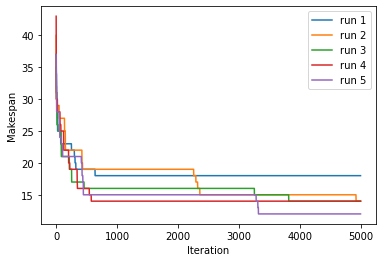

In [ ]:
# plt.figure(figsize=(9,6))
plt.xlabel("Iteration")
plt.ylabel("Makespan")
for run, data in enumerate(runs_makespan):
    plt.plot(data, label=f'run {run+1}')
plt.legend()
plt.show()

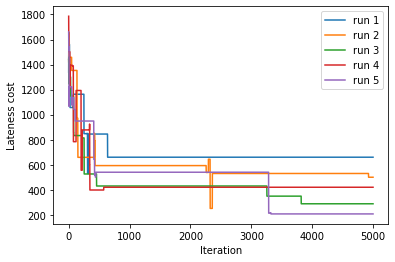

In [ ]:
# plt.figure(figsize=(19,9))
plt.xlabel("Iteration")
plt.ylabel("Lateness cost")
for run, data in enumerate(runs_lateness_cost):
    plt.plot(data, label=f'run {run+1}')
plt.legend()
plt.show()

## f2(x): Minimizando custo de atraso

In [ ]:
best_schedule = list()
runs_lateness_cost = list()
runs_makespan = list()

for run in range(5):
    schedule, list_lateness_cost, list_makespan = run_vns('lateness_cost')
    best_schedule.append(schedule.get_schedule())
    runs_makespan.append(np.array(list_makespan))
    runs_lateness_cost.append(np.array(list_lateness_cost))

In [ ]:
best_makespan = [run[-1] for run in runs_makespan]
best_lateness_cost = [run[-1] for run in runs_lateness_cost]

In [ ]:
print(f'O valor mínimo de custo de atraso foi de {np.min(best_lateness_cost)}')
print(f'O valor máximo de custo de atraso foi de {np.max(best_lateness_cost)}')
print(f'O desvio padrão de custo de atraso foi de {np.std(best_lateness_cost)}')

O valor mínimo de custo de atraso foi de 94.0
O valor máximo de custo de atraso foi de 468.0
O desvio padrão de custo de atraso foi de 133.77054982319538


In [ ]:
print(f'O valor mínimo de makespan foi de {np.min(best_makespan)}')
print(f'O valor máximo de makespan foi de {np.max(best_makespan)}')
print(f'O desvio padrão de makespan foi de {np.std(best_makespan)}')

O valor mínimo de makespan foi de 13.0
O valor máximo de makespan foi de 32.0
O desvio padrão de makespan foi de 7.138627319029898


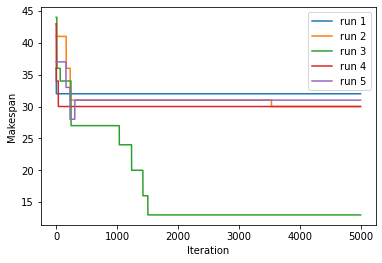

In [ ]:
# plt.figure(figsize=(19,9))
plt.xlabel("Iteration")
plt.ylabel("Makespan")
for run, data in enumerate(runs_makespan):
    plt.plot(data, label=f'run {run+1}')
plt.legend()
plt.show()

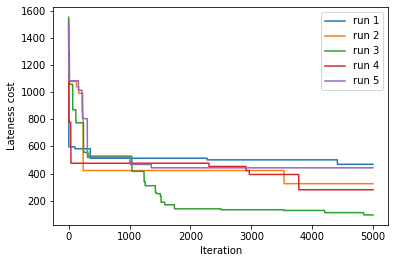

In [ ]:
# plt.figure(figsize=(19,9))
plt.xlabel("Iteration")
plt.ylabel("Lateness cost")
for run, data in enumerate(runs_lateness_cost):
    plt.plot(data, label=f'run {run+1}')
plt.legend()
plt.show()